In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

#from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

/Users/makoto/homebrew/Caskroom/miniforge/base/envs/rsna2023/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
wandb.login()
os.environ["WANDB_NOTEBOOK_NAME"] = "RSNA2023ATDEfficientnet"

### Configs

In [4]:
class CFG:
    wandb         = True

    '''
    competition   = 'RSNA2023ATD' 
    _wandb_kernel = 'm-noda'
    debug         = False
    comment       = 'EfficientNetV1B1-512x512-lr2-vflip'
    exp_name      = 'baseline-v5: ds-v3 + multi_head' 
    '''
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 0
    display_plot = True

    # device
    #device = "TPU-VM" #or "GPU"

    model_name = 'EfficientNet'

    seed = 123

    folds = 5
    
    # which folds to train
    selected_folds = [0, 1]

    # size of the image
    img_size = [512, 512]

    batch_size = 8
    epochs = 12

    loss      = 'BCE & CCE'
    
    optimizer = 'Adam'

    augment   = True

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    '''
    # dropout
    drop_prob   = 0.6
    drop_cnt    = 5
    drop_size   = 0.05
    
    # cut-mix-up
    mixup_prob = 0.0
    mixup_alpha = 0.5
    cutmix_prob = 0.0
    cutmix_alpha = 2.5
    '''

    # pixel-augment
    p_pixel_aug = 0.90
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # test-time augs
    tta = 1
    
    # target column
    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"] # not using "bowel_healthy" & "extravasation_healthy"


### Seeding for reproducibility

In [5]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


### Prepare train data, test data

In [54]:

# make dataframes
train_df = pd.read_csv("./train_df.csv")
train_paths = glob('./train_png/*_*_*.png')
train_df['image_path'] = f'./train_png/' + \
                            train_df.patient_id.astype(str) + '_' + \
                            train_df.series_id.astype(str) + '_' + \
                            train_df.img_number.astype(str).str.zfill(3) + '.png'
'''
train_df = train_df.dropna(subset=['img_number'])
train_df = train_df.dropna(subset=['patient_id'])
train_df = train_df.dropna(subset=['series_id'])
'''

test_paths = glob('./test_png/*_*_*.png')
test_df = pd.DataFrame(test_paths, columns=["image_path"])
test_df['patient_id'] = test_df.image_path.map(lambda x: x.split('_')[-3].replace('png/','')).astype(int)
test_df['series_id'] = test_df.image_path.map(lambda x: x.split('_')[-2]).astype(int)
test_df['img_number'] = test_df.image_path.map(lambda x: x.split('_')[-1].replace('.png','')).astype(int)

In [51]:
'''
train_df = pd.read_csv("./train_df.csv")
print(train_df.shape)
train_df.head()
'''

(490134, 18)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,img_number,injury_name
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,0,Active_Extravasation
1,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,1,Active_Extravasation
2,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,2,Active_Extravasation
3,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,3,Active_Extravasation
4,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1,21057,4,Active_Extravasation


### Data split into train and valid

In [55]:
train_df['stratify'] = ''

for col in CFG.target_col:
    train_df['stratify'] += train_df[col].astype(str)

train_df = train_df.reset_index(drop=True)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)

for  fold , (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['stratify'], train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

pd.set_option('display.max_rows', 100)
display(train_df.groupby(['fold', 'patient_id']).size())

fold  patient_id
0.0   96            130
      318           134
      384           110
      470           103
      496           133
                   ... 
4.0   65289         147
      65326         130
      65438         251
      65450         132
      65495         149
Length: 3147, dtype: int64

### Data Augmentation

In [10]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)


# make affine transformation matrix
# https://cs.kwansei.ac.jp/prog1/affine.html
def get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift):
    
    # degrees to radians
    shear = math.pi * shear / 180


    def get_3x3_mat(list):
        return tf.reshape(tf.concat([list], axis=0), [3, 3])
    

    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')


    # for shear matrix
    cos = tf.math.cos(shear)
    sin = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one,  sin,  zero,
                                zero, cos,  zero,
                                zero, zero, one])
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero,
                               zero,            one/width_zoom, zero,
                               zero,            zero,           one])
    
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    #　return composite transformation
    return K.dot(shear_matrix, k.dot(zoom_matrix, shift_matrix))
    

# apply affine transformation
def transform(image, DIM=CFG.img_size):

    # add padding to align image sizes
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]

    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]

    rotation     = CFG.rot * tf.random.normal([1], dtype='float32')
    rotation     = math.pi * rotation / 180.
    shear        = CFG.shr * tf.random.normal([1], dtype='float32') 
    height_zoom  = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    width_zoom   = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    height_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    width_shift  = CFG.wshift * tf.random.normal([1], dtype='float32')

    # inverse of get_matrix
    # https://daeudaeu.com/reverse-matorix/
    transformation_matrix     =tf.linalg.inv(get_matrix(shear, height_zoom, width_zoom, height_shift, width_shift))
    transformation_matrix_flat=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)

    # apply affine transformation to image
    image=tfa.image.transform(image, transformation_matrix_flat, fill_mode=CFG.fill_mode)

    # rotate image
    image=tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)

    # remove padding
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[pad[0]:-pad[1],:,:]

    # align image sizes
    image = tf.reshape(image, [*DIM, 4])  

    return image


# apply dropout to image
def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, cutout = 5, size = 0.1):

    # boolean to int
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)

    if (P==0) or (cutout==0) or (size==0):
        return image
    
    for c in range(cutout):

        # choose random coordinates
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)

        # determine cutout square
        width = tf.cast(size*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-width//2)
        yb = tf.math.minimum(DIM[0],y+width//2)
        xa = tf.math.maximum(0,x-width//2)
        xb = tf.math.minimum(DIM[1],x+width//2)

        # image after cutout
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,4], dtype = image.dtype) # cutouted square
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,4])

    return image


# apply color augmentation
def ColorAug(image, PROBABILITY):

    if random_float() > prob:
        return image
    
    shape = tf.shape(image)

    # separate alpha channel
    image_rgb, image_alpha = image[:, :, :3], img[:, :, 3:]

    # apply random color adjustment to the RGB channels
    image_rgb = tf.image.random_hue(image_rgb, CFG.hue)
    image_rgb = tf.image.random_saturation(image_rgb, CFG.sat[0], CFG.sat[1])
    image_rgb = tf.image.random_contrast(image_rgb, CFG.cont[0], CFG.cont[1])
    image_rgb = tf.image.random_brightness(image_rgb, CFG.bri)

    # combine the adjusted RGB channels with the original alpha channel
    image = tf.concat([image_rgb, image_alpha], axis=-1)

    image = tf.reshape(image, shape)

    return image

### Data Pipline
1. Reads the PNG file and then decode it to tf.tensor
2. Resizes the image
3. Changes the datatype to float32
4. Cache the data for boosting up the speed
5. Apply augmentations 
6. Split the data into baches

In [59]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):

    def decode_image(path):
        
        file_binary = tf.io.read_file(path)

        if ext == 'png':
            image = tf.image.decode_png(file_binary, channels=4, dtype=tf.uint8)

        else:
            raise ValueError("Image extension not supported")

        image = tf.image.resize(image, target_size, method='bilinear')
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*target_size, 4])

        return image


    def decode_label(label):
        
        label = tf.cast(label, tf.float32)

        return(label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    

    def decode_with_labels(path, label):
        
        return decode_image(path), decode_label(label)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):

    def augment(image, DIM=dim):

        if random_float() < CFG.transform:
            image = transform(image, DIM=DIM)

        image = tf.image.random_flip_left_right(image) if CFG.hflip else image
        image = tf.image.random_flip_up_down(image) if CFG.vflip else image
        image = ColorAug(image, prob=CFG.p_pixel_aug)
        image = tf.clip_by_value(image, 0, 1)  if CFG.clip else image     
        image = tf.reshape(img, [*dim, 4])

    def augment_with_labels(image, label):

        return augment(image), label
    
    return augment_with_labels if with_labels else augment
    

# https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3
def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    # https://tensorflow.classcat.com/2019/03/23/tf20-alpha-guide-data-performance/
    AUTO = tf.data.experimental.AUTOTUNE

    slices = paths if labels is None else (paths, labels)

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds

    if augment and labels is not None:
        ds = ds.map(lambda image, label: (dropout(image, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.drop_prob, 
                                               cutout=CFG.drop_cnt,
                                               size=CFG.drop_size), label),num_parallel_calls=AUTO)

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    
    ds = ds.prefetch(AUTO)

    return ds

### Visualize augmented images

In [95]:
def display_batch(batch, size=2):

    if isinstance(batch, tuple):
        images, targets = batch
    
    else:
        images = batch
        targets = None
    
    targets = tf.concat(targets, axis=1).numpy()

    plt.figure(figsize=(size*5, 10))
    fig, axes = plt.subplots(1, size)

    for image_idx in range(size):
        
        ax = axes[image_idx]
        
        if targets is not None:
            ax.set_title(f'{targets[image_idx].round(2)}', fontsize=6)
        '''
        plt.subplots(num_rows=1, num_cols=size, image_idx+1)
        if targets is not None:
            plt.title(f'{targets[image_idx].round(2)}', fontsize=12)
        '''
        image = images[image_idx, ]
        plt.imshow(image)
        plt.xticks([]); plt.yticks([])
    
    plt.tight_layout()
    plt.show()

In [85]:
fold = 0
fold_df = train_df[train_df.fold==fold].sample(frac=1.0)
paths = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values

ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)

ds = ds.unbatch().batch(20)
batch = next(iter(ds))

<Figure size 1500x1000 with 0 Axes>

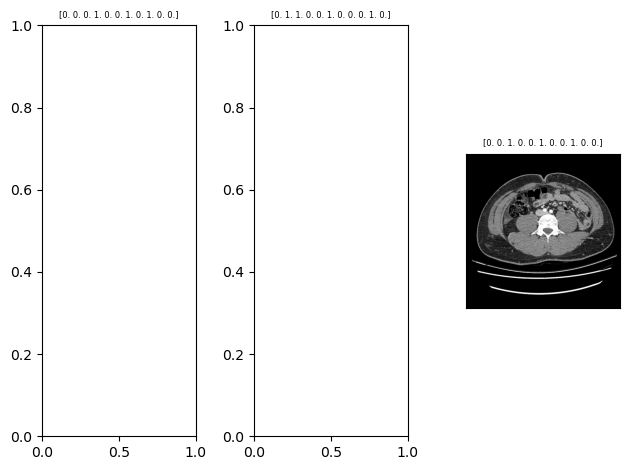

In [96]:
display_batch(batch, 3)

<Figure size 1500x1000 with 0 Axes>

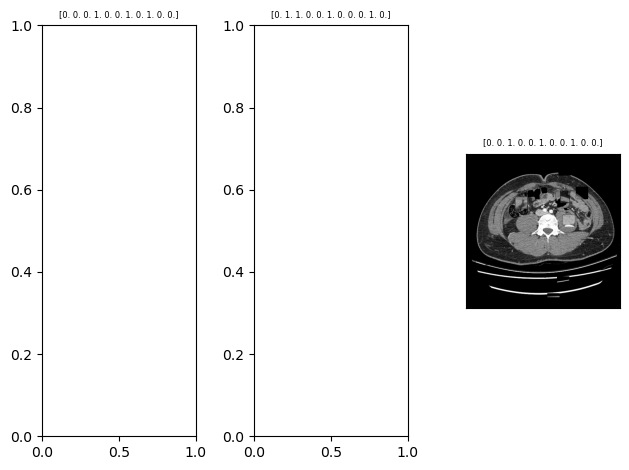

In [87]:
dimgs = tf.map_fn(lambda img: dropout(img,
                DIM=CFG.img_size, 
                PROBABILITY=1.0, 
                cutout=10,
                size=0.08), batch[0])
dtars = batch[1]
display_batch((dimgs, dtars), 3);